In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.image import imread
import os
import sys



import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from nobatch import *

In [3]:
# spatial transcriptomics data
count = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/filtered_matrix.tsv",
                    sep="\t", index_col=0).T

meta = pd.read_csv("./data/Filtered/filtered_ST_matrix_and_meta_data/meta_data.tsv",
                   sep="\t", index_col=0)

genes_new = pd.read_csv("./data/genes_new.txt")
count.columns = list(genes_new.x.values)

count = count.loc[:, count.columns.notna()]

In [4]:
adata_st_list_raw = []

for i in range(1, 10):
    count_i = count[[loc.split("x")[0]==str(i+4) for loc in count.index]]
    count_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in count_i.index]
    meta_i = meta[[loc.split("x")[0]==str(i+4) for loc in meta.index]]
    meta_i.index = [(loc.split("x")[1]+"x"+loc.split("x")[2]) for loc in meta_i.index]

    loc_i = pd.read_csv("./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/spot_data-all-ST_Sample_6.5PCW_%d.tsv" % (i, i),
                       sep="\t")

    loc_i.index = [(str(loc_i.x.values[k]) + 'x' + str(loc_i.y.values[k])) for k in range(loc_i.shape[0])]
    loc_i = loc_i.loc[meta_i.index]

    img_i = imread('./data/ST_Samples_6.5PCW/ST_Sample_6.5PCW_%d/ST_Sample_6.5PCW_%d_HE_small.jpg' % (i, i))

    adata_st_i = ad.AnnData(X = count_i.values)

    adata_st_i.obs = meta_i
    adata_st_i.obs['selected'] = loc_i['selected'].values
    adata_st_i.var.index = count_i.columns

    library_id = '0'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"]['0'] = dict()
    adata_st_i.uns["spatial"]['0']['images'] = dict()
    adata_st_i.uns["spatial"]['0']['images']['hires'] = img_i
    adata_st_i.uns["spatial"]['0']['scalefactors'] = {'spot_diameter_fullres': 100,
                                                      'tissue_hires_scalef': 1.0,
                                                      'fiducial_diameter_fullres': 100,
                                                      'tissue_lowres_scalef': 1.0}

    adata_st_i.obsm['spatial'] = np.concatenate((loc_i['pixel_x'].values.reshape(-1, 1),
                                                 loc_i['pixel_y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obsm['loc_use'] = np.concatenate((loc_i['x'].values.reshape(-1, 1),
                                                 loc_i['y'].values.reshape(-1, 1)), axis=1)

    adata_st_i.obs['array_row'] = loc_i['y'].values
    adata_st_i.obs['array_col'] = loc_i['x'].values

    adata_st_i = adata_st_i[adata_st_i.obs['selected'].values != 0]
    adata_st_list_raw.append(adata_st_i.copy())

In [5]:
# single-cell reference data
count_ref = pd.read_csv("./data/Filtered/share_files/all_cells_count_matrix_filtered.tsv",
                        sep='\t', index_col=0).T

meta_ref = pd.read_csv("./data/Filtered/share_files/all_cells_meta_data_filtered.tsv",
                        sep='\t', index_col=0)

adata_ref = ad.AnnData(X = count_ref.values)
adata_ref.obs.index = count_ref.index
adata_ref.var.index = count_ref.columns
for col in meta_ref.columns[:-1]:
    adata_ref.obs[col] = meta_ref.loc[count_ref.index][col].values

In [6]:
count_ref = pd.read_csv("./data/Filtered/share_files/all_cells_count_matrix_filtered.tsv",
                        sep='\t', index_col=0).T

meta_ref = pd.read_csv("./data/Filtered/share_files/all_cells_meta_data_filtered.tsv",
                        sep='\t', index_col=0)

adata_ref = ad.AnnData(X = count_ref.values)
adata_ref.obs.index = count_ref.index
adata_ref.var.index = count_ref.columns
for col in meta_ref.columns[:-1]:
    adata_ref.obs[col] = meta_ref.loc[count_ref.index][col].values

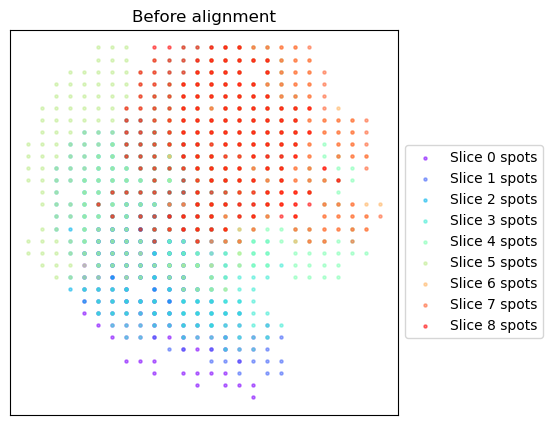

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


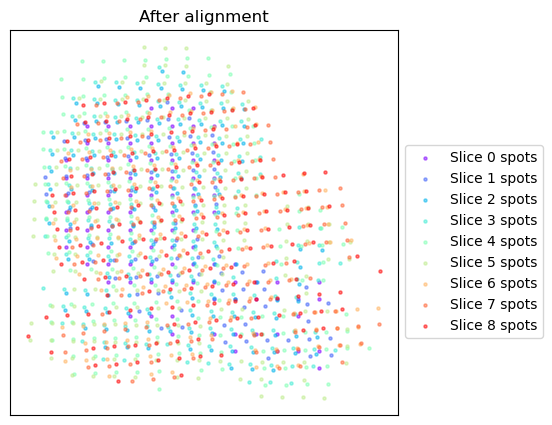

In [7]:
adata_st_list = nobatch.utils.align_spots(adata_st_list_raw, data_type = "ST", coor_key="loc_use", test_all_angles=True, plot=True)

In [8]:
adata_st, adata_basis = nobatch.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col="experiment",
                                                  rad_cutoff=1.1, c2c_dist=200., coor_key="loc_use",
                                                  slice_dist_micron=[5., 115., 85., 160.,
                                                                     5., 160., 5., 155.,],
                                                  n_hvg_group=500)

Finding highly variable genes...
3837 highly variable genes selected.
Calculate basis for deconvolution...
2 batches are used for computing the basis vector of cell type <Atrial cardiomyocytes>.
2 batches are used for computing the basis vector of cell type <Capillary endothelium>.
2 batches are used for computing the basis vector of cell type <Cardiac neural crest cells >.
2 batches are used for computing the basis vector of cell type <Endothelium / pericytes >.
2 batches are used for computing the basis vector of cell type <Epicardial cells>.
2 batches are used for computing the basis vector of cell type <Epicardium-derived cells>.
2 batches are used for computing the basis vector of cell type <Erythrocytes>.
2 batches are used for computing the basis vector of cell type <Fibroblast-like >.
1 batches are used for computing the basis vector of cell type <Immune cells>.
2 batches are used for computing the basis vector of cell type <Myoz2-enriched cardiomyocytes>.
1 batches are used fo

In [9]:
model = nobatch.model.Model(adata_st, adata_basis, training_steps = 2000)

model.train(step_interval=100)


  0%|          | 1/2000 [00:00<10:31,  3.16it/s]

Step: 0, Loss: 168.3008, d_loss: 162.5888, f_loss: 57.1199


  5%|▌         | 101/2000 [00:22<06:34,  4.81it/s]

Step: 100, Loss: -396.5410, d_loss: -399.8595, f_loss: 33.1851


 10%|█         | 201/2000 [00:42<05:30,  5.44it/s]

Step: 200, Loss: -413.5059, d_loss: -416.7876, f_loss: 32.8171


 15%|█▌        | 302/2000 [01:02<05:07,  5.53it/s]

Step: 300, Loss: -419.8923, d_loss: -423.1580, f_loss: 32.6573


 20%|██        | 401/2000 [01:20<05:07,  5.19it/s]

Step: 400, Loss: -422.8244, d_loss: -426.0798, f_loss: 32.5535


 25%|██▌       | 502/2000 [01:40<04:28,  5.57it/s]

Step: 500, Loss: -425.3799, d_loss: -428.6283, f_loss: 32.4844


 30%|███       | 602/2000 [01:58<03:43,  6.26it/s]

Step: 600, Loss: -427.2931, d_loss: -430.5342, f_loss: 32.4108


 35%|███▌      | 702/2000 [02:17<03:37,  5.96it/s]

Step: 700, Loss: -421.5213, d_loss: -424.7610, f_loss: 32.3969


 40%|████      | 802/2000 [02:36<03:52,  5.15it/s]

Step: 800, Loss: -431.3236, d_loss: -434.5490, f_loss: 32.2542


 45%|████▌     | 902/2000 [02:54<03:12,  5.69it/s]

Step: 900, Loss: -432.6446, d_loss: -435.8628, f_loss: 32.1813


 50%|█████     | 1002/2000 [03:11<02:46,  6.00it/s]

Step: 1000, Loss: -431.9896, d_loss: -435.2018, f_loss: 32.1219


 55%|█████▌    | 1102/2000 [03:30<02:34,  5.81it/s]

Step: 1100, Loss: -432.3031, d_loss: -435.5082, f_loss: 32.0512


 60%|██████    | 1202/2000 [03:49<02:31,  5.26it/s]

Step: 1200, Loss: -434.9015, d_loss: -438.0975, f_loss: 31.9595


 65%|██████▌   | 1301/2000 [04:07<02:15,  5.15it/s]

Step: 1300, Loss: -435.7401, d_loss: -438.9286, f_loss: 31.8840


 70%|███████   | 1401/2000 [04:25<01:56,  5.12it/s]

Step: 1400, Loss: -436.6465, d_loss: -439.8257, f_loss: 31.7917


 75%|███████▌  | 1502/2000 [04:46<01:34,  5.29it/s]

Step: 1500, Loss: -433.3905, d_loss: -436.5685, f_loss: 31.7800


 80%|████████  | 1602/2000 [05:05<01:09,  5.75it/s]

Step: 1600, Loss: -437.0758, d_loss: -440.2381, f_loss: 31.6237


 85%|████████▌ | 1702/2000 [05:23<00:53,  5.62it/s]

Step: 1700, Loss: -437.9559, d_loss: -441.1067, f_loss: 31.5083


 90%|█████████ | 1801/2000 [05:42<00:34,  5.84it/s]

Step: 1800, Loss: -435.7633, d_loss: -438.9092, f_loss: 31.4593


 95%|█████████▌| 1901/2000 [06:00<00:19,  5.06it/s]

Step: 1900, Loss: -438.8838, d_loss: -442.0132, f_loss: 31.2940


100%|██████████| 2000/2000 [06:18<00:00,  5.28it/s]


In [10]:
save_path = "./results/human_heart/no_batch"

result = model.eval(adata_st_list_raw, save=True, output_path=save_path)

In [12]:
sc.pp.neighbors(model.adata_st, use_rep='latent', n_neighbors=30)
sc.tl.louvain(model.adata_st, resolution=0.5)

model.adata_st.obs["louvain"].to_csv(os.path.join(save_path, "clustering_result.csv"))

In [13]:
for i, adata_st_i in enumerate(result):
    adata_st_i.obs["louvain"] = model.adata_st.obs.loc[adata_st_i.obs_names, ]["louvain"]

In [1]:

for i, adata_st_i in enumerate(result):
    sc.pl.spatial(result[i], img_key="hires", color=["louvain"], size=1.5, title = "slice_%d" % (i),)

NameError: name 'result' is not defined